<a href="https://colab.research.google.com/github/joyceee916/ATMS-597-SP-2020-Project-4/blob/master/Project4_Joyce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline 
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd

In [3]:
cd /content/drive/My Drive/ATMS 597/Project4

/content/drive/My Drive/ATMS 597/Project4


Tasks
1. Use multiple linear regression to predict weather using past Global Forecast System (GFS) forecast data. 

2. Use random forest regression to predict weather using past GFS forecast data. 

Predict these variables for the period 6 UTC to 6 UTC the following day: 
* Maximum Temperature (C)
* Minimum Temperature (C)
* Maximum Wind Speed (m/s)
* Total precipitation accumulation (mm)



Day 0 at 12 UTC: you will have a model run (that's given to you)
* can incorporate observations up to but not including 00UTC 
* at the point of 00UTC will predict from 06UTC to 06UTC the next day 

Have 2 observational files (can be used in training, can also be used for verification)
* KCMI_hourly.csv
* KCMI_daily_obs.csv
* ^^ have to sum hourly observations to get total precipitation, has daily values even though the column heading says "hourly"

use pr1h or pr6h to correct for seasonal biases? (seems optional?) 

from the GFS: 
* daily.tar.gz, prof.tar.gz, sfc.tar.gz (UNIX zip files)
* for each run they contain a csv file that has the GFS forecast data 
* sfc.tar.gz - has a lot of data if you want to play around with it (sounds optional)
* prof.tar.gz - some upper air values (includes ~5 pressure levels) (can include if you want to) (sounds optional)
* each run has a timestamp that starts at 12UTC

main challenge: to get data lined up in Pandas 

start simple: start with a few variables and do a multiple linear regression, make sure things are working right 

could generate a persistence variable, try to predict tomorrow's data 

then could slowly add in more variables as you get more confidence 

could select different columns and see if your biases get better or worse as you swap out different columns - could write a function for this? 

2019 as a validation set 

calculate one metric: the RMS error (performance metric)

this week, focus on getting data read in and organized 



NOW: CAN SUBSTITUTE BICYCLE RIDERS IN WITH TEMPERATURE DATA (MODULE 4 NOTEBOOK 1): PREDICT TEMPERATURE TOMORROW 

KCMI Observational Data

In [0]:
KCMI_df = pd.read_csv("KCMI_daily_format.csv", parse_dates=True, index_col='Date')

In [0]:
KCMI_df.rename(columns={'TMAX(C)': 'Max_Temp', 'TMIN(C)': 'Min_Temp', 'WMAX(M/s)': 'Max_Wind', 'PREC(mm}': 'Total_Precip'}, inplace = True)


In [6]:
KCMI_df.head()

,Max_Temp,Min_Temp,Max_Wind,Total_Precip
Date,,,,
2010-01-01,-11.111111,-16.666667,6.70560,0.0
2010-01-02,-14.444444,-20.555556,6.70560,0.0
2010-01-03,-12.222222,-21.111111,4.91744,0.0
2010-01-04,-11.666667,-18.888889,8.94080,0.0
2010-01-05,-12.222222,-18.333333,7.15264,0.0


In [0]:
Practice_KCMI_df = KCMI_df[:]

GFS Model Data

In [0]:
GFS_df = pd.read_csv("GFS_daily_2010_2019_test.csv", parse_dates=True, index_col='Time')
GFS_df.drop(columns="Unnamed: 0", inplace=True)

In [9]:
GFS_df.head()

,TMAX,TMIN,WMAX,RTOT
Time,,,,
2010-01-01 12:00:00,-11.26,-16.46,7.323933,0.05
2010-01-02 12:00:00,-10.16,-15.96,4.687217,0.00
2010-01-03 12:00:00,-9.96,-14.36,5.941380,0.06
2010-01-04 12:00:00,-8.46,-12.86,5.685068,0.17
2010-01-05 12:00:00,-7.16,-11.06,3.794733,0.77


In [0]:
Practice_GFS_df = GFS_df[:]

Linear Regression 

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [12]:
# TODO change to the actual file (not practice)
Practice_GFS_df.dropna(inplace=True)
x = Practice_GFS_df.drop(['RTOT'], axis=1)
y = Practice_GFS_df['RTOT']

# split into training and testing sets (10% vs 90%)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, random_state=123)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(3280, 3) (365, 3) (3280,) (365,)


In [13]:
Practice_GFS_df.head()

,TMAX,TMIN,WMAX,RTOT
Time,,,,
2010-01-01 12:00:00,-11.26,-16.46,7.323933,0.05
2010-01-02 12:00:00,-10.16,-15.96,4.687217,0.00
2010-01-03 12:00:00,-9.96,-14.36,5.941380,0.06
2010-01-04 12:00:00,-8.46,-12.86,5.685068,0.17
2010-01-05 12:00:00,-7.16,-11.06,3.794733,0.77


In [14]:
Practice_KCMI_df[(Practice_KCMI_df.index == '2018-02-10')]

,Max_Temp,Min_Temp,Max_Wind,Total_Precip
Date,,,,
2018-02-10,-2.222222,-6.111111,8.04672,0.3


In [15]:
# Create Model 
lin_model = LinearRegression()
lin_model.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [20]:
Practice_KCMI_df.index.month.unique()
Practice_KCMI_df.index.day.unique()
#Practice_KCMI_df[Practice_KCMI_df.index.month==2]


Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31],
           dtype='int64', name='Date')

In [0]:
df['hr_sin'] = np.sin(df.hr*(2.*np.pi/24))

Coefficients: 
 [-0.30333005  0.51926422  0.91569786]
Mean squared error: 67.75
Coefficient of determination: 0.05


Text(0.5, 1.0, 'Linear Regression')

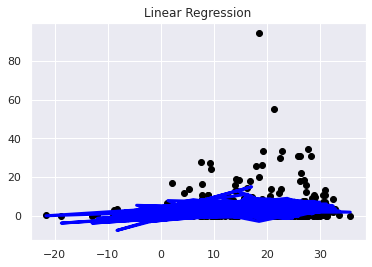

In [0]:
# Print parameters and plot - GFS Data
print('Coefficients: \n', lin_model.coef_)
print('Mean squared error: %.2f' % mean_squared_error(y_test, lin_model.predict(x_test)))
print('Coefficient of determination: %.2f' % r2_score(y_test, lin_model.predict(x_test)))

plt.scatter(x_test['TMAX'], y_test, color='black')
plt.plot(x_test['TMAX'], lin_model.predict(x_test), color='blue', linewidth=3)

plt.title('Linear Regression')

Coefficients: 
 [-0.28871629  0.42220272  0.42909241]
Mean squared error: 46.24
Coefficient of determination: 0.07


Text(0.5, 1.0, 'Linear Regression')

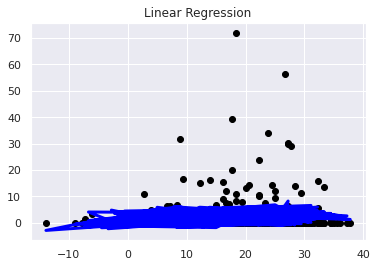

In [0]:
# Print parameters and plot - KCMI Observational Data 
print('Coefficients: \n', lin_model.coef_)
print('Mean squared error: %.2f' % mean_squared_error(y_test, lin_model.predict(x_test)))
print('Coefficient of determination: %.2f' % r2_score(y_test, lin_model.predict(x_test)))

plt.scatter(x_test['Max_Temp'], y_test, color='black')
plt.plot(x_test['Max_Temp'], lin_model.predict(x_test), color='blue', linewidth=3)

plt.title('Linear Regression')

Machine Learning

Adapted from:
https://nbviewer.jupyter.org/github/srnghn/ml_example_notebooks/blob/master/Predicting%20Yacht%20Resistance%20with%20Decision%20Trees%20%26%20Random%20Forests.ipynb?source=post_page---------------------------

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
# TODO change back to KCMI_daily 
Practice_KCMI_df.dropna(inplace=True)
x = Practice_KCMI_df.drop(['Total_Precip'], axis=1)
y = Practice_KCMI_df['Total_Precip']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, random_state=123)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(3250, 3) (362, 3) (3250,) (362,)


Decision Tree Regressor

In [0]:
from sklearn.tree import DecisionTreeRegressor 
tree_model = DecisionTreeRegressor()
tree_model.fit(x_train, y_train) 

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

Random Forest Regressor

In [0]:
from sklearn.ensemble import RandomForestRegressor 
rf_model = RandomForestRegressor()
rf_model.fit(x_train, y_train)

Evaluating Models

In [0]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt

In [0]:
# TODO look up difference between mean squared error and mean absolute error 
tree_mse = mean_squared_error(y_train, tree_model.predict(x_train))
tree_mae = mean_absolute_error(y_train, tree_model.predict(x_train))

In [0]:
rf_mse = mean_squared_error(y_train, rf_model.predict(x_train))
rf_mae = mean_absolute_error(y_train, rf_model.predict(x_train))

In [0]:
print("Decision Tree training mse = ",tree_mse," & mae = ",tree_mae," & rmse = ", sqrt(tree_mse))
print("Random Forest training mse = ",rf_mse," & mae = ",rf_mae," & rmse = ", sqrt(rf_mse))

Decision Tree training mse =  0.7920415384615386  & mae =  0.13707179487179488  & rmse =  0.8899671558330333
Random Forest training mse =  5.903048984577272  & mae =  1.1619857821733826  & rmse =  2.429619102776662


In [0]:
tree_test_mse = mean_squared_error(y_test, tree_model.predict(x_test))
tree_test_mae = mean_absolute_error(y_test, tree_model.predict(x_test))
rf_test_mse = mean_squared_error(y_test, rf_model.predict(x_test))
rf_test_mae = mean_absolute_error(y_test, rf_model.predict(x_test))

In [0]:
print("Decision Tree test mse = ",tree_test_mse," & mae = ",tree_test_mae," & rmse = ", sqrt(tree_test_mse))
print("Random Forest test mse = ",rf_test_mse," & mae = ",rf_test_mae," & rmse = ", sqrt(rf_test_mse))

Decision Tree test mse =  86.2934468999386  & mae =  3.484069981583793  & rmse =  9.28942661846998
Random Forest test mse =  53.994336775528815  & mae =  3.223383316890292  & rmse =  7.348083884627939
